# Customer Segmentation

In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.stats

%matplotlib inline

# Load and View the Dataset

In [0]:
cs_df = pd.read_excel(io=r'/content/drive/My Drive/Customer Segmentation/Online Retail.xlsx')

In [114]:
cs_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [115]:
cs_df.shape

(541909, 8)

# Top Sales by Country

In [116]:
cs_df.Country.value_counts().reset_index().head(n=10)

,index,Country
0,United Kingdom,495478
1,Germany,9495
2,France,8557
3,EIRE,8196
4,Spain,2533
5,Netherlands,2371
6,Belgium,2069
7,Switzerland,2002
8,Portugal,1519
9,Australia,1259


# Top Customers contributing to 10% of total Sales

In [117]:
cs_df.CustomerID.unique().shape

(4373,)

In [118]:
(cs_df.CustomerID.value_counts()/sum(cs_df.CustomerID.value_counts())*100).head(n=13).cumsum()

17841.0    1.962249
14911.0    3.413228
14096.0    4.673708
12748.0    5.814728
14606.0    6.498553
15311.0    7.110850
14646.0    7.623350
13089.0    8.079807
13263.0    8.492020
14298.0    8.895138
15039.0    9.265809
14156.0    9.614850
18118.0    9.930462
Name: CustomerID, dtype: float64

# Analyzing Data Quality Issues

In [119]:
cs_df.StockCode.unique().shape

(4070,)

In [120]:
cs_df.Description.unique().shape

(4224,)

In [121]:
cs_df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [0]:
cat_des_df = cs_df.groupby(["StockCode","Description"]).count().reset_index()

In [123]:
cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1].reset_index().head()

,index,StockCode
0,20713,8
1,23084,7
2,85175,6
3,21830,6
4,23131,5


In [124]:
cs_df[cs_df['StockCode'] == cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1]
      .reset_index()['index'][5]]['Description'].unique()

array(['SET/3 ROSE CANDLE IN JEWELLED BOX', 'wet pallet', 'damages',
       '???missing', 'AMAZON'], dtype=object)

In [0]:
cs_df['invdatetime'] = pd.to_datetime(cs_df.InvoiceDate)

In [126]:
cs_df.Quantity.describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

In [127]:
cs_df.UnitPrice.describe()

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

# Data Cleaning

In [0]:
# Seperate data for one geography
cs_df = cs_df[cs_df.Country == 'United Kingdom']

# Seperate attribute for total amount
cs_df['amount'] = cs_df.Quantity*cs_df.UnitPrice

# Remove negative or return transactions
cs_df = cs_df[~(cs_df.amount<0)]
cs_df.head()
cs_df = cs_df[~(cs_df.CustomerID.isnull())]

In [129]:
cs_df.shape

(354345, 10)

# Build Recency Feature

In [130]:
cs_df.InvoiceDate.max()

Timestamp('2011-12-09 12:49:00')

In [131]:
cs_df.InvoiceDate.min()

Timestamp('2010-12-01 08:26:00')

In [0]:
refrence_date = cs_df.InvoiceDate.max()
refrence_date = refrence_date + datetime.timedelta(days = 1)

In [0]:
cs_df['days_since_last_purchase'] = refrence_date - cs_df.InvoiceDate
cs_df['days_since_last_purchase_num'] = cs_df['days_since_last_purchase'].astype('timedelta64[D]')

In [134]:
customer_history_df = cs_df.groupby("CustomerID").min().reset_index()[['CustomerID', 'days_since_last_purchase_num']]
customer_history_df.rename(columns={'days_since_last_purchase_num':'recency'}, inplace=True)
customer_history_df.recency.describe()

count    3921.000000
mean       92.188472
std        99.528995
min         1.000000
25%        18.000000
50%        51.000000
75%       143.000000
max       374.000000
Name: recency, dtype: float64

In [135]:
customer_history_df.head()

,CustomerID,recency
0,12346.0,326.0
1,12747.0,2.0
2,12748.0,1.0
3,12749.0,4.0
4,12820.0,3.0


In [136]:
customer_history_df.recency.describe()

count    3921.000000
mean       92.188472
std        99.528995
min         1.000000
25%        18.000000
50%        51.000000
75%       143.000000
max       374.000000
Name: recency, dtype: float64

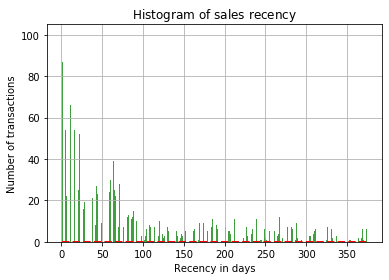

In [137]:
x = customer_history_df.recency
mu = np.mean(customer_history_df.recency)
sigma = math.sqrt(np.var(customer_history_df.recency))
n, bins, patches = plt.hist(x, 1000, facecolor='green', alpha=0.75)
# add a 'best fit' line
y = scipy.stats.norm.pdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.xlabel('Recency in days')
plt.ylabel('Number of transactions')
plt.title(r'$\mathrm{Histogram\ of\ sales\ recency}\ $')
plt.grid(True)

# Build Frequency & Monetary value Features

In [0]:
customer_monetary_val = cs_df[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()
customer_history_df = customer_history_df.merge(customer_monetary_val, how='outer')
customer_history_df.amount = customer_history_df.amount+0.001
customer_freq = cs_df[['CustomerID', 'amount']].groupby("CustomerID").count().reset_index()
customer_freq.rename(columns={'amount':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_freq, how='outer')

In [139]:
customer_history_df.head()

,CustomerID,recency,amount,frequency
0,12346.0,326.0,77183.601,1
1,12747.0,2.0,4196.011,103
2,12748.0,1.0,33719.731,4596
3,12749.0,4.0,4090.881,199
4,12820.0,3.0,942.341,59


In [140]:
from sklearn import preprocessing
import math

customer_history_df['recency_log'] = customer_history_df['recency'].apply(math.log)
customer_history_df['frequency_log'] = customer_history_df['frequency'].apply(math.log)
customer_history_df['amount_log'] = customer_history_df['amount'].apply(math.log)
feature_vector = ['amount_log', 'recency_log','frequency_log']
X_subset = customer_history_df[feature_vector].as_matrix()
scaler = preprocessing.StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



# Visualizing Recency vs Monetary Value (scaled)

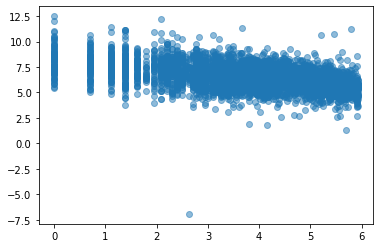

In [141]:
plt.scatter(customer_history_df.recency_log, customer_history_df.amount_log, alpha=0.5)

# Visualizing Monetary Value distribution (scaled)

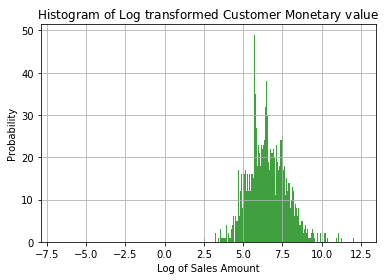

In [142]:
x = customer_history_df.amount_log
n, bins, patches = plt.hist(x, 1000, facecolor='green', alpha=0.75)

plt.xlabel('Log of Sales Amount')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ Log\ transformed\ Customer\ Monetary\ value}\ $')
plt.grid(True)
#plt.show()

In [143]:
customer_history_df.head()

,CustomerID,recency,amount,frequency,recency_log,frequency_log,amount_log
0,12346.0,326.0,77183.601,1,5.786897,0.000000,11.253942
1,12747.0,2.0,4196.011,103,0.693147,4.634729,8.341890
2,12748.0,1.0,33719.731,4596,0.000000,8.432942,10.425838
3,12749.0,4.0,4090.881,199,1.386294,5.293305,8.316516
4,12820.0,3.0,942.341,59,1.098612,4.077537,6.848367


Text(0.5, 0, 'Monetary')

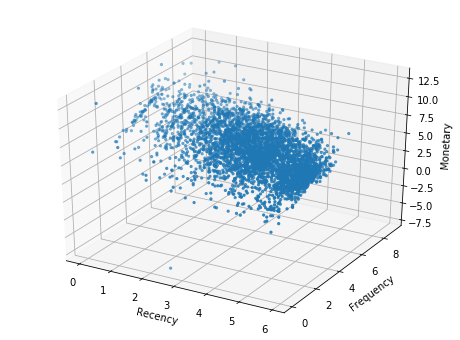

In [144]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

xs =customer_history_df.recency_log
ys = customer_history_df.frequency_log
zs = customer_history_df.amount_log
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

#plt.show()

# Analyze Customer Segments with Clustering

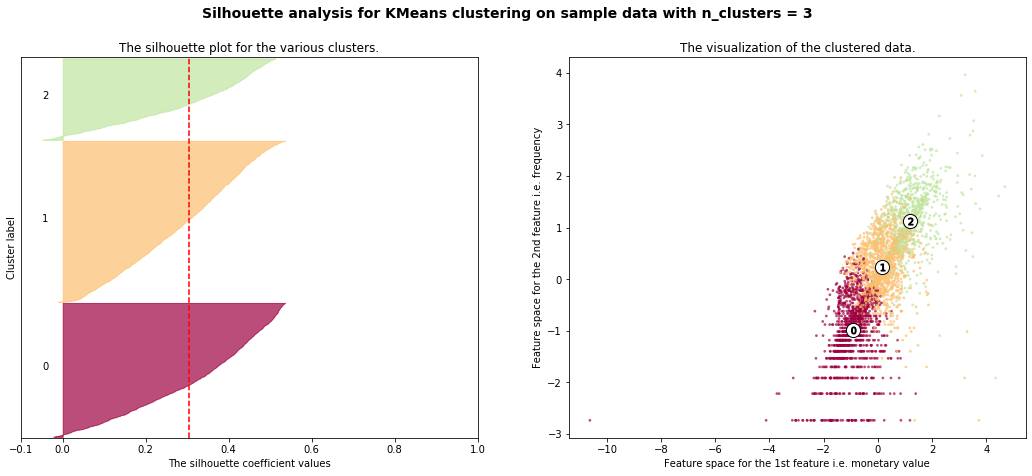

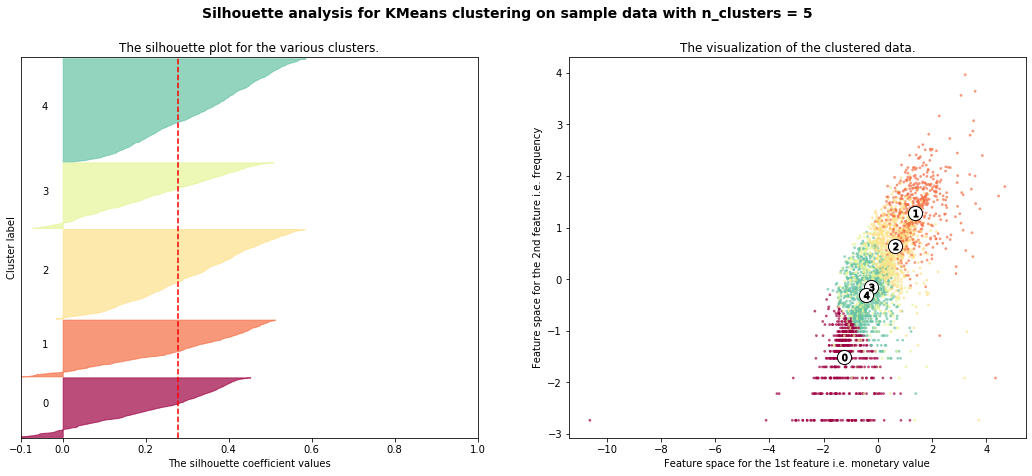

In [145]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

X = X_scaled

cluster_centers = dict()

for n_clusters in range(3,6,2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    #ax2 = plt.subplot(111, projection='3d')
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    cluster_centers.update({n_clusters :{
                                        'cluster_center':clusterer.cluster_centers_,
                                        'silhouette_score':silhouette_avg,
                                        'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    feature1 = 0
    feature2 = 2
    ax2.scatter(X[:, feature1], X[:, feature2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, feature1], centers[:, feature2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[feature1], c[feature2], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature i.e. monetary value")
    ax2.set_ylabel("Feature space for the 2nd feature i.e. frequency")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    #plt.show()

In [146]:
for i in range(3,6,2):
    print("for {} number of clusters".format(i))
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=feature_vector))
    print("Silhouette score for cluster {} is {}". format(i, cluster_centers[i]['silhouette_score']))
    print()

for 3 number of clusters
    amount_log  recency_log  frequency_log
0   220.198311   122.258999      10.545038
1   828.741744    44.343353      53.275214
2  3158.748880     7.396805     177.087308
Silhouette score for cluster 3 is 0.30344910866275493

for 5 number of clusters
    amount_log  recency_log  frequency_log
0   144.581761   121.494119       5.203414
1  3983.000207     5.669752     216.919083
2  1529.103414    48.475555      93.359920
3   491.225157    13.227883      31.937363
4   407.421058   138.857191      25.576757
Silhouette score for cluster 5 is 0.2782580724931221

